<a href="https://colab.research.google.com/github/KillerStrike17/EVA-5/blob/master/5.%20Code%20Drill/EVA5_Code_Drill_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is Version 1 of the code drill

The main focus here is to get a model which gives decent accuracy in less parameters.. even if it increases the benchmark.. it is totally fine..

## Importing Libraries



In [1]:
import torch 
import torch.nn as nn # All NN Layers
import torch.nn.functional as F # to get loss fucnction
import torch.optim as optim # Optimizer Fucntion
from torchvision import datasets, transforms #Loading Dataset and transform function to perform transformation
from torchsummary import summary # To view summary
%matplotlib inline
import matplotlib.pyplot as plt # To plot graphs
from torch.optim.lr_scheduler import StepLR,OneCycleLR, ReduceLROnPlateau
from tqdm import tqdm


## Data Transformation

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(), # Converting to Tensor
                                       transforms.Normalize((0.1307,),(0.3081,)) # Normalizing the dataset with the mean and std 
                                      ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                    transforms.ToTensor(), # Converting to Tensor
                                    transforms.Normalize((0.1307,),(0.3081,))  # Normalizing the dataset using mean and std
                                  ])

## Dataset Cleaning and Train/Test Split

In [3]:
train = datasets.MNIST('./data',train= True,download= True, transform = train_transforms) # Downloading Train set
test = datasets.MNIST('./data',train= False,download= True, transform = test_transforms) # Downloading Test set

## CONSTANTS

In [4]:
SEED = 1
BATCHSIZE = 128
BATCHSIZE_2 = 64
NUM_OF_WORKER = 4
EPOCHS = 15

## Data Loading

In [5]:
# Checking for CUDA
cuda = torch.cuda.is_available()
print("CUDA Available",cuda)

torch.manual_seed(SEED)
if cuda:
  torch.cuda.manual_seed(SEED)

dataloader_args= dict(shuffle = True, batch_size = BATCHSIZE, num_workers = NUM_OF_WORKER,pin_memory = True) if cuda else dict(shuffle = True, batch_size  = BATCHSIZE_2)

train_loader = torch.utils.data.DataLoader(train, **dataloader_args) # creating train data loader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args) # creating test dataloader

CUDA Available True


## The Model

In [6]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()

    # Convolution Block 1
    self.convblock1 = nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=16,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(16),
    )

    # Convolution Block 2
    self.convblock2 = nn.Sequential(
        nn.Conv2d(in_channels=16,out_channels=64,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(64),
    )

    # Transition Block 1
    self.transitionblock1 = nn.Sequential(
        nn.Conv2d(in_channels = 64,out_channels = 32,kernel_size = (3,3),padding = 0,bias = False),
        nn.MaxPool2d(2,2)
    )

    # Convolution Block 3
    self.convblock3= nn.Sequential(
        nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(64),
    )

    # Convolution Block 4
    self.convblock4= nn.Sequential(
        nn.Conv2d(in_channels=64,out_channels=64,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(64),
    )

    self.convblock5= nn.Sequential(
        nn.Conv2d(in_channels=64,out_channels=64,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(64),
    )

    self.gap = nn.Sequential(
        nn.AvgPool2d(kernel_size=5),
        nn.Conv2d(in_channels=64,out_channels=10,kernel_size=(1,1),padding = 0, bias = True)
    )
  
  def forward(self, x):
    x = self.convblock1(x)
    x = self.convblock2(x)
    x = self.transitionblock1(x)
    x = self.convblock3(x)
    x = self.convblock4(x)
    x = self.convblock5(x)
    x = self.gap(x)
    x = x.view(-1,10)
    return F.log_softmax(x,dim = -1)



## Model Parameters
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [7]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
            Conv2d-4           [-1, 64, 24, 24]           9,216
              ReLU-5           [-1, 64, 24, 24]               0
       BatchNorm2d-6           [-1, 64, 24, 24]             128
            Conv2d-7           [-1, 32, 22, 22]          18,432
         MaxPool2d-8           [-1, 32, 11, 11]               0
            Conv2d-9             [-1, 64, 9, 9]          18,432
             ReLU-10             [-1, 64, 9, 9]               0
      BatchNorm2d-11             [-1, 64, 9, 9]             128
           Conv2d-12             [-1, 64, 7, 7]          36,864
             ReLU-13             [-1, 64, 7, 7]               0
      BatchNorm2d-14             [-1, 6

In [8]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))

In [9]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.08749368041753769 Batch_id=468 Accuracy=95.36: 100%|██████████| 469/469 [00:11<00:00, 41.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0453, Accuracy: 9881/10000 (98.81%)

EPOCH: 1


Loss=0.04116912558674812 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:11<00:00, 41.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0314, Accuracy: 9912/10000 (99.12%)

EPOCH: 2


Loss=0.02201155014336109 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:11<00:00, 40.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9927/10000 (99.27%)

EPOCH: 3


Loss=0.011467516422271729 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:11<00:00, 40.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9935/10000 (99.35%)

EPOCH: 4


Loss=0.032836321741342545 Batch_id=468 Accuracy=99.54: 100%|██████████| 469/469 [00:11<00:00, 40.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9921/10000 (99.21%)

EPOCH: 5


Loss=0.015708889812231064 Batch_id=468 Accuracy=99.65: 100%|██████████| 469/469 [00:11<00:00, 40.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9923/10000 (99.23%)

EPOCH: 6


Loss=0.0027359698433429003 Batch_id=468 Accuracy=99.68: 100%|██████████| 469/469 [00:11<00:00, 40.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9939/10000 (99.39%)

EPOCH: 7


Loss=0.01663796231150627 Batch_id=468 Accuracy=99.76: 100%|██████████| 469/469 [00:11<00:00, 40.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9951/10000 (99.51%)

EPOCH: 8


Loss=0.0016841246979311109 Batch_id=468 Accuracy=99.84: 100%|██████████| 469/469 [00:11<00:00, 40.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9931/10000 (99.31%)

EPOCH: 9


Loss=0.0020777478348463774 Batch_id=468 Accuracy=99.89: 100%|██████████| 469/469 [00:11<00:00, 40.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 9948/10000 (99.48%)

EPOCH: 10


Loss=0.0017316428711637855 Batch_id=468 Accuracy=99.89: 100%|██████████| 469/469 [00:11<00:00, 39.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9944/10000 (99.44%)

EPOCH: 11


Loss=0.001827479456551373 Batch_id=468 Accuracy=99.91: 100%|██████████| 469/469 [00:11<00:00, 40.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9944/10000 (99.44%)

EPOCH: 12


Loss=0.004282612819224596 Batch_id=468 Accuracy=99.92: 100%|██████████| 469/469 [00:11<00:00, 39.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9937/10000 (99.37%)

EPOCH: 13


Loss=0.002619717037305236 Batch_id=468 Accuracy=99.93: 100%|██████████| 469/469 [00:11<00:00, 39.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9944/10000 (99.44%)

EPOCH: 14


Loss=0.004430788103491068 Batch_id=468 Accuracy=99.97: 100%|██████████| 469/469 [00:11<00:00, 39.87it/s]



Test set: Average loss: 0.0156, Accuracy: 9950/10000 (99.50%)



Text(0.5, 1.0, 'Test Accuracy')

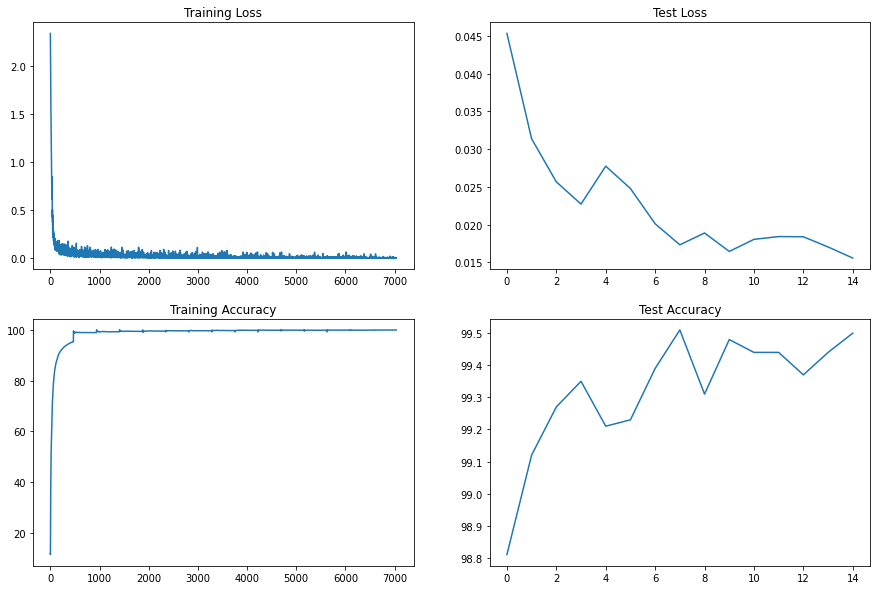

In [10]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")